# Лабораторная работа 2. Классификация. MNIST

---


### Этапы работы:
* анализ MNIST
* обучение классификатора и агментация данных
* поиск числового набора данных и обучение классификатора для него
* поиск набора изображений и обучение классификатора


#### 1. Показатели  
Когда мы учим компьютер распознавать разные объекты, важно понять, насколько он делает это хорошо. Для этого используют три главных показателя: точность, полноту и F1-score. Они помогают понять, насколько правильно и полно модель определяет нужные объекты.
#### 2. Точность  
Точность показывает, сколько раз модель оказалась права, когда сказала, что на картинке есть нужный объект. Например, если модель сказала «Это символ 9» сто раз, а правильно оказалось только 80 раз, то точность — 80%. То есть, из всех случаев, когда модель утверждала, что видит символ 9, 80% раз она была права.  

Формула для вычисления точности:   
$$
\text{Precision} = \frac{\text{Количество правильных ответов, когда модель сказала «это нужный символ»}}{\text{Сколько всего раз модель сказала «это нужный символ»}}
$$

 
#### 3. Полнота  
Полнота показывает, сколько из всех реальных объектов модель смогла найти. Например, если в тесте было 100 картинок с символом 9, а модель правильно определила только 70, то полнота — 70%. То есть, модель не пропустила 70% нужных картинок, а остальные 30% не заметила.

Формула для вычисления полноты:
$$
\text{Recall} = \frac{\text{Количество правильных ответов, когда модель сказала «это нужный символ»}}{\text{Общее количество таких символов в тесте}}
$$
 
#### 4. F1-score  
F1-score — это число, которое объединяет точность и полноту в один показатель. Оно показывает, насколько модель хорошо справляется в целом: чтобы оно было большим, нужно, чтобы и точность, и полнота были высокими. Если модель часто ошибается или пропускает много нужных объектов, F1-score будет низким.  

Формула для F1-score:
$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

#### 5. Зачем нужны эти показатели

Если мы хотим, чтобы модель редко ошибалась и её предсказания были надёжными, то важно смотреть на точность — это показывает, насколько часто модель права, когда говорит, что нашла нужный символ. Если же задача в том, чтобы ни один нужный символ не остался незамеченным, то важна полнота — она показывает, какую часть всех настоящих символов модель действительно распознала. Иногда приходится выбирать, что важнее: не пропускать нужные объекты или не ошибаться, говоря, что объект есть. Чтобы оценить модель в целом, учитывая и точность, и полноту, используют показатель F1-score — он помогает понять, насколько модель сбалансирована и хорошо работает во всех случаях. Именно эти три показателя помогают нам понять, где модель хороша, а где ещё нужна доработка.




## Импорт необходимых библиотек

---



In [30]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from packaging import version
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

В этой ячейке кода создаем пространство для отображения чисел из MNIST:


In [31]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### Функции
---

In [32]:
from scipy.ndimage import shift, rotate

def augment_with_shift(X, y, max_shift = 1):
  X_augmented = []
  y_augmented = []
  for image, label in zip(X, y):
    image_2d = image.reshape(28, 28)
    for dy, dx in [(max_shift, 0), (-max_shift, 0)]:
      shifted = shift(image_2d, shift=(dy, dx), mode='reflect')
      X_augmented.append(shifted.flatten())
      y_augmented.append(label)
  return np.vstack([X, np.array(X_augmented)]), np.hstack([y, np.array(y_augmented)])

def augment_with_rotate(X, y, angles=[-5, 5]):
  X_augmented = []
  y_augmented = []
  for image, label in zip(X, y):
    image_2d = image.reshape(28, 28)
    for angle in angles:
      rotated = rotate(image_2d, angle, mode='reflect', reshape=False)
      X_augmented.append(rotated.flatten())
      y_augmented.append(label)
  return np.vstack([X, np.array(X_augmented)]), np.hstack([y, np.array(y_augmented)])

def augment_with_shift_china(X, y, max_shift = 1):
  X_augmented = []
  y_augmented = []
  for image, label in zip(X, y):
    image_2d = image.reshape(64, 64)
    for dy, dx in [(max_shift, 0), (-max_shift, 0)]:
      shifted = shift(image_2d, shift=(dy, dx), mode='reflect')
      X_augmented.append(shifted.flatten())
      y_augmented.append(label)
  return np.vstack([X, np.array(X_augmented)]), np.hstack([y, np.array(y_augmented)])

def augment_with_rotate_china(X, y, angles=[-5, 5]):
  X_augmented = []
  y_augmented = []
  for image, label in zip(X, y):
    image_2d = image.reshape(64, 64)
    for angle in angles:
      rotated = rotate(image_2d, angle, mode='reflect', reshape=False)
      X_augmented.append(rotated.flatten())
      y_augmented.append(label)
  return np.vstack([X, np.array(X_augmented)]), np.hstack([y, np.array(y_augmented)])


In [33]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
#Функция создана для сохранения графиков matplotlib в указанную папку, автоматически создавая её, если она не существует.
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Этот код предназначен для сохранения графиков matplotlib в указанную папку, автоматически создавая её, если она не существует.

## Анализ MNIST

---

 MNIST - объёмная база данных образцов рукописного написания цифр. База данных является стандартом, предложенным Национальным институтом стандартов и технологий США с целью калибрации и сопоставления методов распознавания изображений с помощью машинного обучения в первую очередь на основе нейронных сетей  
 База данных MNIST содержит 60000 изображений для обучения и 10000 изображений для тестирования. Половина образцов для обучения и тестирования были взяты из набора NIST для обучения, а другая половина — из набора NIST для тестирования. 
 

### Импортируем датасет MNIST из SKLearn и сохраняем в переменную

In [34]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

### Данные в MNIST

Рассмотрим "ключи", которые есть в датасете.

In [35]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

"DESCR"содержит описание набора данных. Набор содержит в себе 70,000  изображений цифр от 0 до 9. Разрешение изображений 28x28 - 784 "пикселей".

In [36]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

"data" содержит набор массивов, которые представляют из себя изображения цифр.

In [37]:
mnist['data']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

"target" содержит метку, цифру которая изображена на соответствующем массиве.

In [38]:
mnist['target']

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

"categories" состоит из классов из "target".

In [39]:
mnist['categories']

{'class': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}

"details" содержит краткую информацию о наборе в SKLearn.

In [40]:
mnist['details']

{'id': '554',
 'name': 'mnist_784',
 'version': '1',
 'description_version': '2',
 'format': 'ARFF',
 'creator': ['Yann LeCun', 'Corinna Cortes', 'Christopher J.C. Burges'],
 'upload_date': '2014-09-29T03:28:38',
 'language': 'English',
 'licence': 'Public',
 'url': 'https://api.openml.org/data/v1/download/52667/mnist_784.arff',
 'parquet_url': 'https://data.openml.org/datasets/0000/0554/dataset_554.pq',
 'file_id': '52667',
 'default_target_attribute': 'class',
 'tag': ['Artificial Intelligence',
  'AzurePilot',
  'Computer Vision',
  'Data Sets',
  'Kaggle',
  'Machine Learning',
  'OpenML-CC18',
  'OpenML100',
  'study_1',
  'study_123',
  'study_41',
  'study_99',
  'vision'],
 'visibility': 'public',
 'minio_url': 'https://data.openml.org/datasets/0000/0554/dataset_554.pq',
 'status': 'active',
 'processing_date': '2020-11-20 20:12:09',
 'md5_checksum': '0298d579eb1b86163de7723944c7e495'}

"url" Ссылка на набор данных MNIST.

In [41]:
mnist['url']

'https://www.openml.org/d/554'

Краткое описание:  

**data** — матрица с пикселями изображений (каждое изображение — строка)  

**target** — метки классов (цифры от 0 до 9)    

**DESCR** — описание датасета  

**details** — метаданные о датасете  

**categories** — категории классов (если есть)  

**url** — ссылка на источник данных  

Заключим данные в две переменные.

In [42]:
X, y = mnist['data'], mnist['target']

Первое изображение в наборе имеет значение 5

In [43]:
y[0]

'5'

Второе изображение в наборе имеет значение 0

In [44]:
y[1]

'0'

Изобразим первую цифру

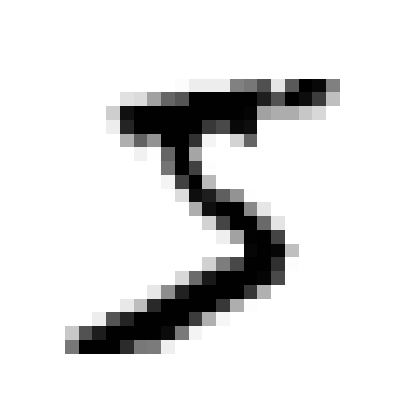

In [45]:
some_digit = X[0]
# Получение первого изображения из набора данных.
some_digit_image = some_digit.reshape(28, 28)
# Преобразование вектора признаков в изображение 28x28 пикселей.
plt.figure(figsize=(5, 5))
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

Изобразим вторую цифру

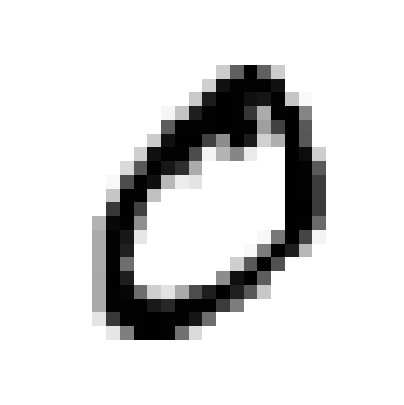

In [46]:
some_digit = X[1]
# Получение первого изображения из набора данных.
some_digit_image = some_digit.reshape(28, 28)
# Преобразование вектора признаков в изображение 28x28 пикселей.
plt.figure(figsize=(5, 5))
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

Получаем такие изображение пятерки и нолика, написанные от руки.

## Создание и обучение классификатора KNeighbors

---



KNeighborsClassifier — это алгоритм классификации из библиотеки scikit-learn, основанный на методе k-ближайших соседей (k-NN).
Основная идея этого метода — определить класс нового объекта по классам его ближайших "соседей" в обучающей выборке.

Как работает алгоритм k-NN:
1) Для каждого нового объекта (теста) вычисляется расстояние до всех объектов из обучающей выборки.
Обычно используется метрика расстояния, например, Евклидово расстояние, Манхэттенское или другие метрики из семейства Lp.

2) Из всех обучающих объектов выбираются k ближайших, где число k задаётся пользователем заранее.

3) Для задачи классификации итоговый прогноз определяется как наиболее часто встречающийся класс (мода) среди этих k соседей.
В задаче регрессии результатом будет среднее значение целевой переменной соседей.

4) Эти шаги повторяются для каждого тестового объекта.




---



Разделим изображения на обучающие(60,000) и тестовые(10,000). Обучим классификатор


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

Ищем наилучшие параметры для классификатора 

In [48]:
# Инициализируем классификатор
knn = KNeighborsClassifier()

# Задаём сетку параметров для поиска
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

# Создаём объект GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Запускаем подбор гиперпараметров на тренировочных данных
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры и лучший результат
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее качество на кросс-валидации:", grid_search.best_score_)
best_knn = grid_search.best_estimator_
test_accuracy = best_knn.score(X_test, y_test)
print("Точность на тестовой выборке:", test_accuracy)

Лучшие параметры: {'n_neighbors': 3, 'weights': 'distance'}
Лучшее качество на кросс-валидации: 0.9713392857142857
Точность на тестовой выборке: 0.9728571428571429


Предсказываем данные

In [49]:
y_pred = best_knn.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 0.9729


Точность > 0.97

## Аугментация данных
---

Аугментация данных — это техника искусственного увеличения объёма обучающей выборки за счёт создания новых примеров путём различных преобразований исходных данных, таких как повороты, сдвиги, масштабирование или добавление шума. Это помогает модели стать более устойчивой к вариациям и улучшить её обобщающую способность, особенно когда исходных данных мало.

С помощью заранее прописанной функции использующей метод shift осуществляем сдвиг изображений вверх и вниз(в данном случае на 1 пиксель).  
С помощью заранее прописанной функции использующей метод rotate осуществляем поворот изображений на -5 и 5 градусов

In [50]:
X_aug, y_aug = augment_with_shift(X_train, y_train, 1)
X_aug_r, y_aug_r = augment_with_rotate(X_train, y_train, angles = [-5, 5])

Количество аугументированных сдвинутых и повернутых данных

In [51]:
print("Количество сдвинутых данных",len(X_aug))
print("Количество сдвинутых данных", len(X_aug_r))

Количество сдвинутых данных 168000
Количество сдвинутых данных 168000


Снова обучим классификатор на аугументированных данных и получим такие результаты:

In [52]:
best_knn.fit(X_aug, y_aug)
y_pred_aug = best_knn.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_aug):.4f}")

Accuracy: 0.9785


In [53]:
best_knn.fit(X_aug_r, y_aug_r)
y_pred_aug_r = best_knn.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_aug_r):.4f}")

Accuracy: 0.9774


Точность возросла на 0.05

In [54]:
print(classification_report(y_test, y_pred_aug_r))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1343
           1       0.97      0.99      0.98      1600
           2       0.98      0.97      0.98      1380
           3       0.97      0.97      0.97      1433
           4       0.98      0.98      0.98      1295
           5       0.97      0.98      0.98      1273
           6       0.99      0.99      0.99      1396
           7       0.97      0.98      0.97      1503
           8       0.99      0.95      0.97      1357
           9       0.96      0.97      0.97      1420

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



Аугментация данных, несмотря на небольшой прирост, заметно улучшила качество модели. Добавление сдвигов и поворотов помогло модели лучше обрабатывать вариации изображений и повысить её устойчивость к искажениям. Благодаря этому точность предсказаний стала выше, что особенно важно при ограниченном количестве обучающих данных. Такой подход помогает избежать переобучения и улучшить обобщающую способность модели. В итоге аугментация оказалась полезным инструментом для повышения надёжности классификации. Даже небольшие улучшения могут существенно сказаться на качестве работы в реальных задачах.

### Классификация телефонов
---

Датасет содержит информацию о технических характеристиках различных моделей мобильных телефонов и их ценовых диапазонах. Цель использования данных — выявить взаимосвязь между параметрами устройств (например, объём оперативной памяти, встроенной памяти и других особенностей) и приблизительной стоимостью. Это помогает определить ценовую категорию телефона на основе его характеристик, что полезно для оценки рыночной стоимости новых моделей, оптимизации ценовой политики и понимания факторов, влияющих на цену в условиях конкурентного рынка мобильных устройств.


In [55]:
dfphones = pd.read_csv("phones.csv")
dfphones

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [56]:
xphones = dfphones.drop(columns=['price_range'])  # все столбцы кроме 'Type' — признаки
yphones = dfphones['price_range'] 

### RandomForest  
Для решения задачи классификации ценовых диапазонов часто используют алгоритмы машинного обучения, одним из которых является случайный лес (Random Forest). Этот метод основан на построении множества решающих деревьев, каждое из которых принимает решение о принадлежности телефона к определённой ценовой категории. Результаты отдельных деревьев объединяются для повышения точности и устойчивости модели. Случайный лес хорошо справляется с задачами, где данные имеют большое количество признаков и сложные зависимости, а также помогает избежать переобучения, что делает его эффективным инструментом для анализа и прогнозирования в подобных задачах. 
 
Дерево решений строится путём последовательного разбиения исходных данных на более однородные подмножества на основе значений признаков. На каждом узле дерева выбирается такой признак и пороговое значение, которые максимально разделяют данные по классам (в задаче классификации) или минимизируют ошибку (в регрессии). Для этого используются критерии, такие как энтропия, индекс Джини или среднеквадратичная ошибка. Процесс деления повторяется рекурсивно, пока не будет достигнут заданный критерий остановки — например, максимальная глубина дерева или минимальное число объектов в листовом узле.

В итоге дерево состоит из узлов с условиями разбиения и листьев, которые содержат итоговое решение — класс или значение целевой переменной. Для классификации листовой узел присваивает метку класса, чаще всего встречающегося в этом подмножестве данных.

Когда дерево применяется к новому объекту, его признаки последовательно проверяются согласно условиям узлов, и объект проходит по ветвям дерева от корня к листу. В листовом узле получается предсказание модели для данного объекта.

Модель случайного леса — это множество таких деревьев, каждое из которых построено на случайной выборке данных и случайном подмножестве признаков. Для предсказания новая точка прогоняется через все деревья, и результаты их классификации объединяются голосованием большинства. Такой ансамблевый подход уменьшает вероятность ошибок и делает модель более стабильной и точной по сравнению с одним деревом решений.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(xphones, yphones, test_size=0.2, random_state=42)

# Упрощённая "так себе" модель
rf_simple = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42)

rf_simple.fit(X_train, y_train)
y_pred = rf_simple.predict(X_test)
print("Отчёт по классификации на тестовой выборке:")
print(classification_report(y_test, y_pred))


Отчёт по классификации на тестовой выборке:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       105
           1       0.72      0.64      0.67        91
           2       0.63      0.67      0.65        92
           3       0.85      0.84      0.84       112

    accuracy                           0.77       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.77      0.77      0.77       400



Получаем довольно низкую точность  
Каждый четвёртый ответ неверный

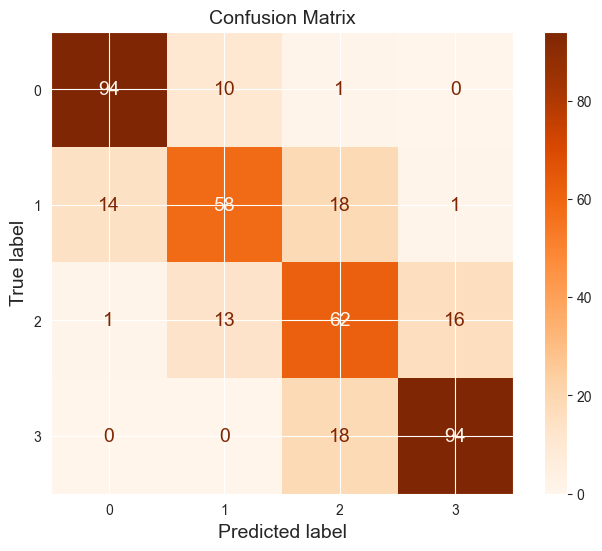

In [58]:
cm = confusion_matrix(y_test, y_pred, labels=rf_simple.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_simple.classes_)

fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()


Попробуем повысить точность модели случайного леса с помощью подбора гиперпараметров — это важный шаг, который помогает найти оптимальные настройки модели для конкретной задачи и данных.

В нашем случае мы будем использовать сеточный поиск (Grid Search), перебирая разные значения основных гиперпараметров модели:

**n_estimators** — количество деревьев в лесу. Чем больше деревьев, тем стабильнее и точнее прогнозы, но увеличивается время обучения и вычислительные ресурсы. Обычно берут от нескольких десятков до нескольких сотен.

**max_depth** — максимальная глубина каждого дерева. Ограничение глубины помогает избежать переобучения: слишком глубокие деревья «запоминают» данные, а слишком мелкие могут плохо учиться.

**min_samples_split** — это минимальное количество объектов (примеров) в узле (то есть в текущей точке дерева), при котором дерево разрешает разделить этот узел на два дочерних. Если в узле объектов меньше этого числа, разбиение не происходит — узел становится листом.

**min_samples_leaf** — это минимальное количество объектов, которое должно оказаться в листовом узле (то есть в конечном «крайнем» узле дерева после разбиения). При делении дерева учитывается, чтобы ни один из новых листьев не содержал меньше объектов, чем этот параметр.

**bootstrap** — использовать ли метод бутстрэп (выборки с возвращением) для формирования обучающей выборки каждого дерева. Если False — все деревья обучаются на одном наборе данных.

In [59]:
# Делим данные
X_train, X_test, y_train, y_test = train_test_split(xphones, yphones, test_size=0.2, random_state=42)


# Создаем базовый классификатор
rf = RandomForestClassifier(random_state=42)

# Параметры для Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],         # число деревьев
    'max_depth': [None, 10, 20, 30],        # глубина дерева
    'min_samples_split': [2, 5, 10],        # минимальное число объектов для разбиения
    'min_samples_leaf': [1, 2, 4],           # минимальное число листьев
    'bootstrap': [True, False]               # использовать ли бутстрэп
}

# Запускаем GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print("Отчёт по классификации на тестовой выборке:")
print(classification_report(y_test, y_pred))

Отчёт по классификации на тестовой выборке:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       105
           1       0.89      0.86      0.87        91
           2       0.80      0.86      0.83        92
           3       0.93      0.88      0.91       112

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



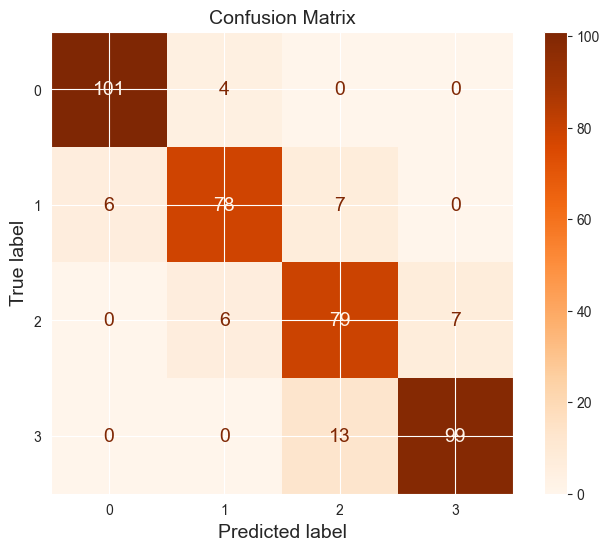

In [60]:
cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)

fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

Подбор гиперпараметров позволил оптимизировать работу модели на числовых данных, что привело к улучшению её точности и способности лучше обобщать информацию, снижая риск переобучения.


### Класификация Chinese MNIST
---

Датасет Chinese MNIST in CSV представляет собой набор данных, содержащий изображения китайских символов. В каждом примере 4096 чисел — это пиксели изображения размером 64×64, где значение пикселя отражает уровень яркости: чем больше число, тем светлее (белее) точка на изображении. То есть пиксели с низкими значениями — это более тёмные участки, а с высокими — более светлые. Кроме того, в датасете присутствуют метки: числовая метка (label), которая обозначает класс символа, и сам символ (character) — иероглиф, изображённый на картинке. Такой датасет используется для задач классификации рукописных или печатных китайских символов.  

In [61]:
df = pd.read_csv('chineseMNIST.csv')
num_samples = df.shape[0]
num_pixels = len([col for col in df.columns if col.startswith('pixel_')])
unique_labels = df['label'].nunique()

print(f'Всего примеров: {num_samples}')
print(f'Размер изображения: {num_pixels} пикселей')
print(f'Уникальных числовых меток: {unique_labels}')

Всего примеров: 15000
Размер изображения: 4096 пикселей
Уникальных числовых меток: 15


Напечатаем два символа из нашего набора данных.

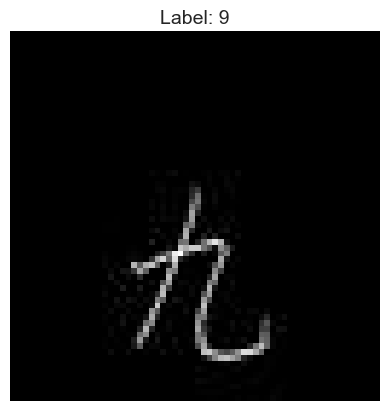

In [62]:
X = df.loc[:, 'pixel_0':'pixel_4095'].values
y = df['label'].values

image = X[0].reshape(64, 64)
label = y[0]


plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()


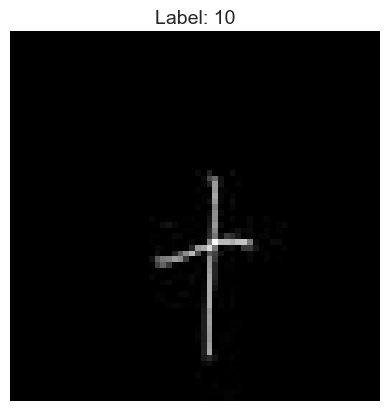

In [63]:
image = X[1000].reshape(64, 64)  # второй символ — индекс 1
label = y[1000]

plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

Попробуем обучить классификатор RandomForest на датасете Chinese MNIST, чтобы он научился угадывать иероглиф по картинке. (По значениям яркости в строке)

In [64]:
# Делим данные на обучающую и тестовую выборки (например, 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем классификатор Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучаем модель
clf.fit(X_train, y_train)

# Делаем предсказания на тесте
y_pred = clf.predict(X_test)

# Оцениваем качество
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print('Classification report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.6107
Classification report:
              precision    recall  f1-score   support

           0       0.51      0.85      0.64       186
           1       0.73      0.95      0.82       182
           2       0.59      0.67      0.63       206
           3       0.54      0.58      0.56       198
           4       0.72      0.69      0.70       194
           5       0.61      0.55      0.58       207
           6       0.53      0.57      0.55       203
           7       0.56      0.56      0.56       201
           8       0.75      0.78      0.77       188
           9       0.60      0.37      0.46       201
          10       0.60      0.76      0.67       189
          11       0.58      0.43      0.50       209
          12       0.66      0.56      0.61       221
          13       0.57      0.45      0.50       217
          14       0.64      0.50      0.56       198

    accuracy                           0.61      3000
   macro avg       0.61      0.62      0

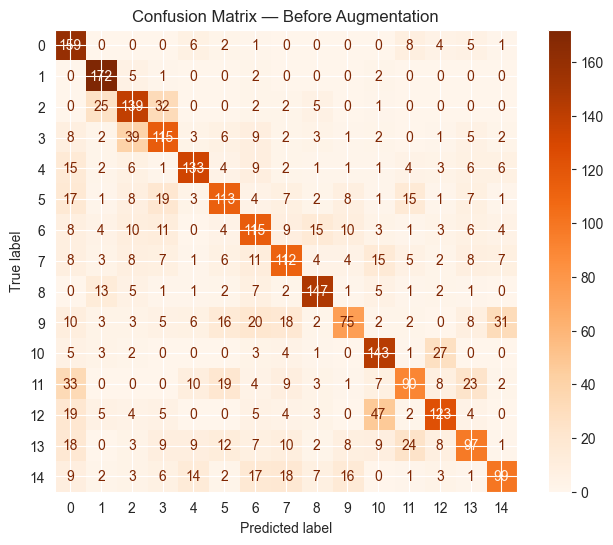

In [59]:
cm_orig = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp_orig = ConfusionMatrixDisplay(confusion_matrix=cm_orig, display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp_orig.plot(ax=ax, cmap=plt.cm.Oranges)
plt.title("Confusion Matrix — Before Augmentation")
plt.show()

Низкая точность предсказаний. Попробуем улучшить нашу модель: аугментируем тренировочные данные, а затем заново обучим классификатор. Тестовые данные оставим без изменений.

In [60]:
# Применим аугментацию со сдвигом
X_aug1, y_aug1 = augment_with_shift_china(X_train, y_train)

# Применим аугментацию с поворотом к уже аугментированным данным
X_final, y_final = augment_with_rotate_china(X_aug1, y_aug1)

print("До аугментации:", X_train.shape[0])
print("После аугментации:", X_final.shape[0])

До аугментации: 15000
После аугментации: 108000


In [61]:
# Обучим случайный лес
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
clf.fit(X_final, y_final)

# Предскажем на тестовой выборке
y_pred = clf.predict(X_test)

# Выведем метрики
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.88      0.77       186
           1       0.83      0.98      0.90       182
           2       0.64      0.83      0.72       206
           3       0.70      0.71      0.71       198
           4       0.82      0.80      0.81       194
           5       0.87      0.70      0.78       207
           6       0.66      0.69      0.67       203
           7       0.72      0.77      0.74       201
           8       0.78      0.84      0.81       188
           9       0.78      0.50      0.61       201
          10       0.67      0.83      0.74       189
          11       0.77      0.59      0.67       209
          12       0.71      0.67      0.69       221
          13       0.76      0.68      0.72       217
          14       0.76      0.63      0.69       198

    accuracy                           0.74      3000
   macro avg       0.74      0.74      0.73      3000
weighted avg       0.74   

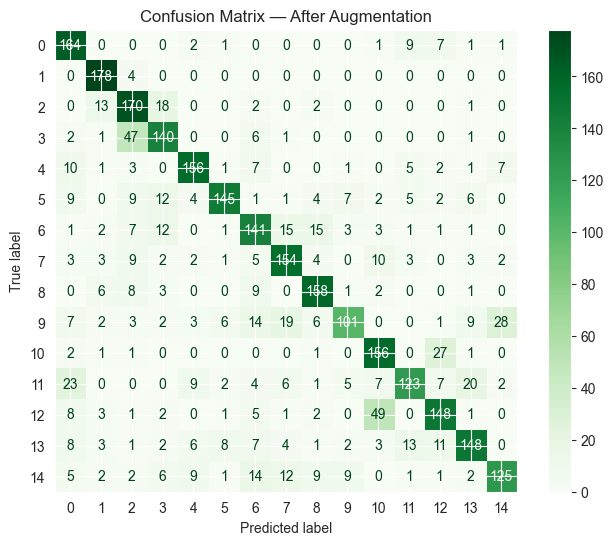

In [62]:
cm_aug = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp_aug = ConfusionMatrixDisplay(confusion_matrix=cm_aug, display_labels=clf.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp_aug.plot(ax=ax, cmap=plt.cm.Greens)
plt.title("Confusion Matrix — After Augmentation")
plt.show()


Несмотря на то, что количество примеров для каждого иероглифа одинаковое, модель чаще всего ошибалась при распознавании символов с метками 9, 11 и 14. Это может быть связано с визуальной схожестью этих иероглифов с другими классами, либо с их сложной структурой, которую труднее выделить на изображении.

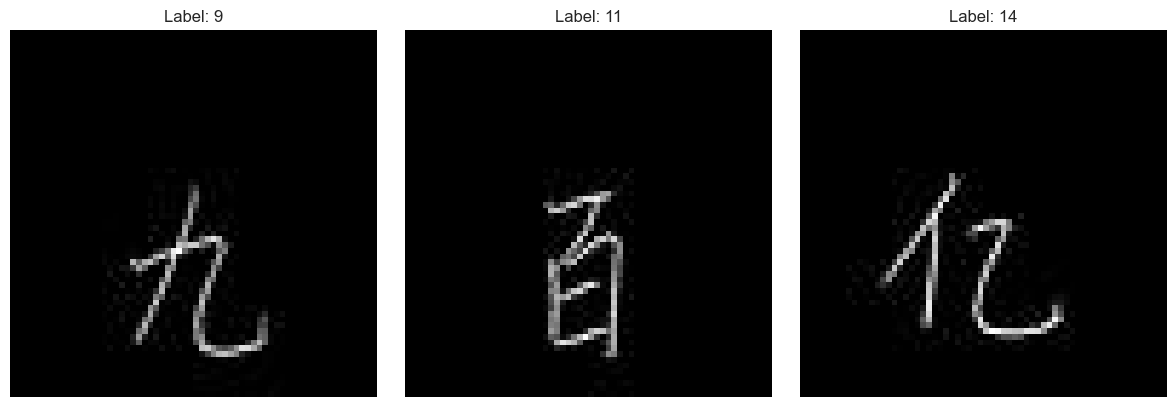

In [63]:
idx_9 = next(i for i, label in enumerate(y) if label == 9)
idx_11 = next(i for i, label in enumerate(y) if label == 11)
idx_14 = next(i for i, label in enumerate(y) if label == 14)

# Восстановим изображения
img_9 = X[idx_9].reshape(64, 64)
img_11 = X[idx_11].reshape(64, 64)
img_14 = X[idx_14].reshape(64, 64)

# Построим изображения
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(img_9, cmap='gray')
axs[0].set_title('Label: 9')
axs[0].axis('off')

axs[1].imshow(img_11, cmap='gray')
axs[1].set_title('Label: 11')
axs[1].axis('off')

axs[2].imshow(img_14, cmap='gray')
axs[2].set_title('Label: 14')
axs[2].axis('off')

plt.tight_layout()
plt.show()

Аугументация данных позволила повысить точность модели примерно на 10%, что уже является заметным улучшением, однако результат всё ещё далёк от идеального. Это говорит о том, что одной аугументации недостаточно: для дальнейшего повышения качества классификации необходимо использовать более сложные подходы. Одним из таких решений являются сверточные нейронные сети (CNN), которые лучше адаптированы к обработке изображений и способны учитывать пространственные зависимости между пикселями, что делает их особенно эффективными в задачах распознавания.

## Сверточные нейронные сети (CNN, от англ. Convolutional Neural Networks)
---
Сверточные нейронные сети (CNN, от англ. Convolutional Neural Networks) — это тип нейросетей, который особенно хорошо работает с изображениями. В отличие от обычных нейросетей, которые просто “смотрят” на набор чисел, CNN “видит” изображение почти так же, как человек: она замечает линии, края, формы и постепенно собирает их в сложные объекты — в нашем случае, в китайские иероглифы.

Мы используем CNN из библиотеки TensorFlow, чтобы улучшить качество распознавания китайских символов. Эта сеть проходит по изображениям, находит характерные признаки и учится отличать одни иероглифы от других. Она автоматически определяет, какие именно особенности изображения важны для распознавания, поэтому её результат получается точнее, чем у простых алгоритмов вроде случайного леса.


In [64]:
# Подготовка данных (как и ранее)
X_train = X_train.reshape(-1, 64, 64, 1).astype('float32') / 255.
X_test = X_test.reshape(-1, 64, 64, 1).astype('float32') / 255.

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

num_classes = y_train_cat.shape[1]

# Модель
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучение
history = model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10


C:\Users\maksi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5065 - loss: 1.5630 - val_accuracy: 0.8717 - val_loss: 0.4252
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8998 - loss: 0.3105 - val_accuracy: 0.9250 - val_loss: 0.2617
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9423 - loss: 0.1673 - val_accuracy: 0.9158 - val_loss: 0.2751
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9666 - loss: 0.1055 - val_accuracy: 0.9375 - val_loss: 0.2060
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9787 - loss: 0.0666 - val_accuracy: 0.9417 - val_loss: 0.2295
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9821 - loss: 0.0559 - val_accuracy: 0.9425 - val_loss: 0.2212
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9907 - loss: 0.0376 - val_accuracy: 0.9592 - val_loss: 0.1833
Epoch 8/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9915 - loss: 0.0271 - val_accuracy: 0.953

In [65]:
# Предсказание классов на тесте
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Классический отчёт
print(classification_report(y_test_enc, y_pred, target_names=le.classes_.astype(str)))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       186
           1       0.96      0.99      0.97       182
           2       0.95      0.92      0.93       206
           3       0.91      0.94      0.93       198
           4       0.98      0.99      0.99       194
           5       0.98      0.92      0.95       207
           6       0.98      0.98      0.98       203
           7       0.97      0.97      0.97       201
           8       0.95      0.99      0.97       188
           9       0.94      0.94      0.94       201
          10       0.89      0.99      0.94       189
          11       0.89      0.96      0.92       209
          12       0.99      0.90      0.94       221
          13       0.97      0.97      0.97       217
          14       0.98      0.93      0.95       198

    accuracy                           0.95      3000
   macro avg       0.96      0.96      0.

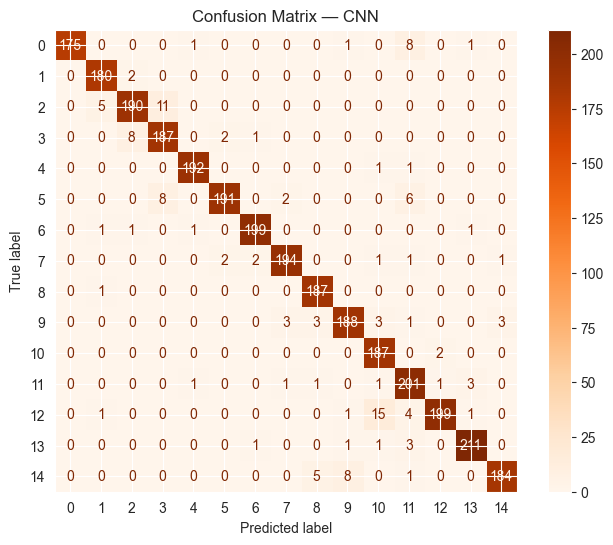

In [66]:
cm = confusion_matrix(y_test_enc, y_pred, labels=range(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Oranges)
plt.title("Confusion Matrix — CNN")
plt.show()

CNN продемонстрировала максимальную точность около 0.95, что значительно превосходит результаты, полученные с помощью случайного леса. Это говорит о том, что использование сверточных нейронных сетей позволяет более эффективно распознавать китайские иероглифы. Кроме того, повышение точности благодаря применению CNN оказалось заметно выше, чем улучшение, достигнутое за счёт аугментации данных. Таким образом, внедрение CNN является более мощным способом улучшения качества модели в нашей задаче.

В ходе лабораторной работы мы убедились, что аугментация данных и подбор гиперпараметров помогают повысить точность модели. Аугментация расширяет тренировочный набор, добавляя вариации изображений, что улучшает обучение, а оптимизация параметров позволяет модели работать эффективнее. Однако результаты ограничены возможностями выбранного алгоритма и характеристиками датасета.

Наиболее заметное улучшение показала сверточная нейронная сеть (CNN), достигшая точности около 95%, что значительно выше, чем у случайного леса. CNN лучше справляется с задачей распознавания иероглифов благодаря способности выявлять пространственные особенности изображений. Это подтверждает, что глубокие методы являются наиболее перспективным инструментом для работы с визуальными данными.

При оценке модели важно смотреть не только на accuracy — общую долю правильных предсказаний, но и на precision (точность, насколько верны положительные предсказания) и recall (полноту, насколько хорошо модель находит все нужные объекты). Аугментация данных может улучшить recall, помогая модели лучше распознавать редкие или сложные классы, либо повысить precision, снижая количество ложных срабатываний. Выбор и значимость этих метрик зависят от конкретной задачи и цели, поэтому всегда нужно учитывать их вместе, чтобы полноценно оценить качество модели.